Downloaded image 1/50 for 'Rose'
Downloaded image 2/50 for 'Rose'
Downloaded image 3/50 for 'Rose'
Error downloading : cannot write mode P as JPEG
Downloaded image 4/50 for 'Rose'
Downloaded image 5/50 for 'Rose'
Downloaded image 6/50 for 'Rose'
Downloaded image 7/50 for 'Rose'
Error downloading data:image/gif;base64,R0lGODlhAQABAIAAAP///////yH5BAEKAAEALAAAAAABAAEAAAICTAEAOw==: cannot write mode P as JPEG
Downloaded image 8/50 for 'Rose'
Error downloading : cannot write mode RGBA as JPEG
Downloaded image 9/50 for 'Rose'
Error downloading : cannot write mode RGBA as JPEG
Downloaded image 10/50 for 'Rose'
Error downloading : cannot write mode P as JPEG
Downloaded image 11/50 for 'Rose'
Downloaded image 12/50 for 'Rose'
Downloaded image 13/50 for 'Rose'
Downloaded image 14/50 for 'Rose'
Error downloading : cannot write mode P as JPEG
Downloaded image 15/50 for 'Rose'
Error downloading : cannot write mode P as JPEG
Downloaded image 16/50 for 'Rose'
Error downloading : cannot write mode RGB
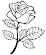
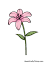
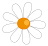
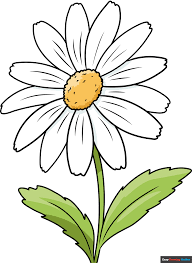
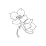
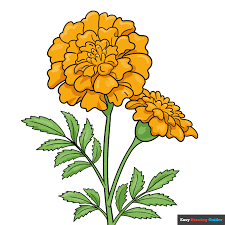
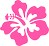
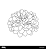
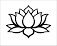
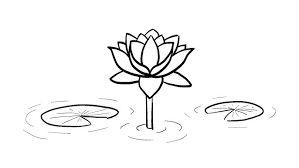
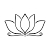
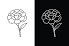

In [14]:
import os
import time
import requests
import base64
import io
from PIL import Image
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Setup Chrome options
chrome_options = Options()
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(options=chrome_options)

# List of 20 flowers
flowers = [
    "Rose", "Tulip", "Sunflower", "Lily", "Orchid",
    "Daisy", "Jasmine", "Marigold", "Lavender", "Hibiscus",
    "Daffodil", "Chrysanthemum", "Bougainvillea", "Lotus", "Carnation",
    "Peony", "Poppy", "Violet", "Geranium", "Begonia"
]

metadata = []

for flower in flowers:
    # Create directory structure
    os.makedirs(f"flowers/{flower}", exist_ok=True)
    
    # Search Google Images
    driver.get(f"https://www.google.com/search?q={flower}+flower&tbm=isch")
    
    # Accept cookies if prompted
    try:
        WebDriverWait(driver, 5).until(
            EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Accept all')]"))
        ).click()
    except:
        pass  # No cookie prompt or different text
    
    # Progressive scrolling to load images
    image_count = 0
    last_height = driver.execute_script("return document.body.scrollHeight")
    
    while image_count < 50:
        for scroll_step in range(10):
            driver.execute_script(f"window.scrollTo(0, {scroll_step * last_height / 10});")
            time.sleep(0.5)
        
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
        
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            try:
                show_more = driver.find_element(By.CSS_SELECTOR, ".mye4qd")
                if show_more.is_displayed():
                    show_more.click()
                    time.sleep(2)
                else:
                    break
            except:
                break
        last_height = new_height
        
        selectors = [
            "img.rg_i", 
            "img.Q4LuWd", 
            "img.YQ4gaf", 
            "img[data-src]",
            "img[src]"
        ]
        
        for selector in selectors:
            img_elements = driver.find_elements(By.CSS_SELECTOR, selector)
            if img_elements:
                break
        
        img_urls = []
        for img in img_elements:
            src = img.get_attribute('src') or img.get_attribute('data-src') or img.get_attribute('data-original')
            if src and src not in img_urls:
                img_urls.append(src)
        
        current_count = image_count
        for img_url in img_urls:
            if image_count >= 50:
                break
                
            try:
                if img_url.startswith('data:image'):
                    img_data = img_url.split(',')[1]
                    img_bytes = base64.b64decode(img_data)
                    img = Image.open(io.BytesIO(img_bytes))
                    filename = f"flowers/{flower}/img_{image_count}.jpg"
                    img.save(filename)
                    resolution = f"{img.width}x{img.height}"
                else:
                    response = requests.get(img_url, timeout=10)
                    if response.status_code == 200:
                        filename = f"flowers/{flower}/img_{image_count}.jpg"
                        with open(filename, "wb") as f:
                            f.write(response.content)
                        
                        img = Image.open(filename)
                        resolution = f"{img.width}x{img.height}"
                    else:
                        continue
                
                metadata.append({
                    "category": flower,
                    "url": img_url,
                    "filename": filename,
                    "resolution": resolution
                })
                
                image_count += 1
                print(f"Downloaded image {image_count}/50 for '{flower}'")
                
            except Exception as e:
                print(f"Error downloading {img_url}: {e}")
        
        if current_count == image_count:
            print(f"No new images found after scrolling. Stopping at {image_count} images for '{flower}'.")
            break

# Save metadata to CSV
df = pd.DataFrame(metadata)
df.to_csv("flowers/metadata.csv", index=False)

driver.quit()
print("✅ Image scraping completed for all flowers!")